In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


### 下载好VGG模型，准备迁移学习

In [2]:
import os
import numpy as np
import tensorflow as tf
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import glob
from tensorflow_vgg import vgg16
from tensorflow_vgg import utils
%matplotlib inline
from scipy.ndimage import imread
import matplotlib.pyplot as plt
import cv2

### 将train中的图片存储，并编程能被训练的codes

In [3]:
data_dir = 'data/train/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

In [4]:
classes

['melanoma', 'nevus', 'seborrheic_keratosis']

In [5]:
import glob
num = 0
for each in classes:
    class_path = data_dir + each
    file_path = glob.glob(class_path+r'/*')
    print(len(file_path))
    num += len(file_path)
labels_train = num
labels_train

374
1372
254


2000

In [6]:
data_dir = 'data/valid/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]
import glob
num = 0
for each in classes:
    class_path = data_dir + each
    file_path = glob.glob(class_path+r'/*')
    print(len(file_path))
    num += len(file_path)
labels_valid = num
labels_valid

30
78
42


150

In [7]:
data_dir = 'data/test/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]
import glob
num = 0
for each in classes:
    class_path = data_dir + each
    file_path = glob.glob(class_path+r'/*')
    print(len(file_path))
    num += len(file_path)
labels_test = num
labels_test

117
393
90


600

In [6]:
import cv2
image = utils.load_image(file_path[0])
res = cv2.resize(image, (224,224))

/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


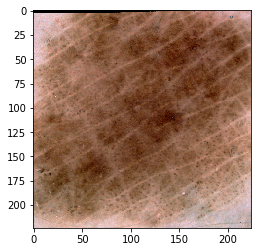

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.imshow(res)

/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


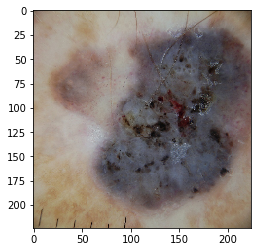

In [8]:

%matplotlib inline

import matplotlib.pyplot as plt
result  = []
from scipy.ndimage import imread
image = utils.load_image(file_path[2])

plt.imshow(image)

/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


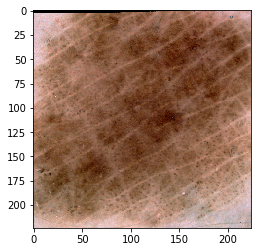

In [9]:

%matplotlib inline

import matplotlib.pyplot as plt
result  = []
from scipy.ndimage import imread
image = utils.load_image(file_path[0])

plt.imshow(image)

    

In [10]:
image.shape[0]

224

In [11]:
image.shape[1]

224

In [12]:
image.shape[2]

3

### 这里提供两种方法，一种是glob另一种是os.listdir

```
import glob

class_path = data_dir + 'melanoma'
print(class_path)
file_path = glob.glob(class_path+r'/*')
len(file_path)
```


In [ ]:
batch_size = 5
codes_list = []
labels = []
batch = []
import cv2
codes = None

with tf.Session() as sess:
    
    # TODO: Build the vgg network here
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
        
    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            img = cv2.resize(img,(224,224))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch)
                
                # TODO: Get the values from the relu6 layer of the VGG network
                feed_dict = {input_: images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                print(codes_batch.shape[0])
                print(codes_batch.shape[1])
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                print(codes.shape[0])
                print(codes.shape[1])
                print(len(labels))
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

/home/carnd/dermatologist-ai/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting melanoma images


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

5
4096
5
4096
5
5 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

5
4096
10
4096
10
10 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

### 将对train图片的处理结果存到指定文件中

In [ ]:
with open('codes_train', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels_train', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

### 开始处理valid

In [9]:
data_dir = 'data/valid/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

In [10]:
batch_size = 20
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    
    # TODO: Build the vgg network here
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224,224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
        
    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            
            img = utils.load_image(os.path.join(class_path, file))
            img = cv2.resize(img,(224,224))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch)
                
                # TODO: Get the values from the relu6 layer of the VGG network
                feed_dict = {input_: images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                print(codes[0])
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

/home/carnd/dermatologist-ai/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting melanoma images


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

ValueError: GraphDef cannot be larger than 2GB.

In [5]:
with open('codes_valid', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels_valid', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

### 开始处理test

In [6]:
data_dir = 'data/test/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

In [86]:
batch_size = 10
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    
    # TODO: Build the vgg network here
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
        
    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            img = cv2.resize(img,(224,224))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch)
                
                # TODO: Get the values from the relu6 layer of the VGG network
                feed_dict = {input_: images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                print(codes[0])
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

/home/carnd/dermatologist-ai/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting melanoma images


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
10 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
20 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
30 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
40 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
50 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
60 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
70 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
80 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
90 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
100 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
110 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
117 images processed
Starting nevus images


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
10 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
20 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
30 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
40 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
50 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
60 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
70 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
80 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
90 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
100 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
110 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
120 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
130 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
140 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
150 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
160 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
170 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
180 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
190 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
200 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
210 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
220 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
230 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
240 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
250 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
260 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
270 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
280 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
290 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
300 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
310 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
320 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
330 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
340 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
350 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
360 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
370 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
380 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
390 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
393 images processed
Starting seborrheic_keratosis images


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
10 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
20 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
30 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
40 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
50 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
60 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
70 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
80 images processed


/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/carnd/anaconda3/envs/dog-project/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

[ 0.          0.87186283  0.         ...,  1.20705986  0.31961063  0.        ]
90 images processed


In [31]:
classes

['melanoma', 'nevus', 'seborrheic_keratosis']

In [32]:
class_path

'data/test/seborrheic_keratosis'

In [128]:
batch_size = 1
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    
    # TODO: Build the vgg network here
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
        
   
    class_path = data_dir + 'seborrheic_keratosis'
    files = os.listdir(class_path)
    for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
        img = utils.load_image(os.path.join(class_path, file))
        img = cv2.resize(img,(224,224))
        batch.append(img.reshape((1, 224, 224, 3)))
        labels.append( 'seborrheic_keratosis')
            
            # Running the batch through the network to get the codes
        if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
            images = np.concatenate(batch)
                
                # TODO: Get the values from the relu6 layer of the VGG network
            feed_dict = {input_: images}
            codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
            if codes is None:
                codes = codes_batch
            else:
                codes = np.concatenate((codes, codes_batch))
            print(codes[0])
                # Reset to start building the next batch
            batch = []
            print('{} images processed'.format(ii))

/home/carnd/dermatologist-ai/tensorflow_vgg/vgg16.npy


KeyboardInterrupt: 

In [87]:
with open('codes_test', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels_test', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

## 处理过程结束，并成功存储
### 这里开始，读取我们处理好的数据，然后进行预测

In [91]:
import csv
import numpy as np
with open('labels_train') as f:
    reader = csv.reader(f, delimiter='\n')
    train_y = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes_train') as f:
    codes = np.fromfile(f, dtype=np.float32)
    train_x = np.reshape(codes,(labels_train,-1))

In [9]:
import csv

with open('labels_valid') as f:
    reader = csv.reader(f, delimiter='\n')
    valid_y = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes_valid') as f:
    codes = np.fromfile(f, dtype=np.float32)
    valid_x = codes.reshape((labels_valid, -1))

In [10]:
import csv

with open('labels_test') as f:
    reader = csv.reader(f, delimiter='\n')
    test_y = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes_test') as f:
    codes = np.fromfile(f, dtype=np.float32)
    test_x = codes.reshape((labels_test, -1))

In [11]:
test_x

array([[  0.        ,   0.87186283,   0.        , ...,   1.20705986,
          0.31961063,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   1.05342507, ...,   4.17916393,
          0.        ,   0.        ],
       ..., 
       [  3.56560302,   0.        ,   0.        , ...,  12.7439661 ,
          0.892241  ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   5.42233467,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.7150048 , ...,   0.        ,
          4.81621218,   0.        ]], dtype=float32)

### 对不同种病进行单热点编码

In [92]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(train_y)

train_y = lb.transform(train_y)

In [93]:
len(train_y)
np.concatenate
train_y1 = train_y[:254]
train_y1 = np.concatenate((train_y1,train_y[254:510]))
train_y1 = np.concatenate((train_y1,train_y[1746:]))


In [95]:
len(train_x)
np.concatenate
train_x1 = train_x[:254]
train_x1 = np.concatenate((train_x1,train_x[254:510]))
train_x1 = np.concatenate((train_x1,train_x[1746:]))


In [137]:
len(train_x1)

764

In [70]:
train_x = train_x[:400]

In [13]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(valid_y)

valid_y = lb.transform(valid_y)

In [14]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(test_y)

test_y = lb.transform(test_y)

### 构建tf全连接层

In [97]:
inputs_ = tf.placeholder(tf.float32, shape=[None, train_x.shape[1]])
labels_ = tf.placeholder(tf.float32, shape=[None, train_y.shape[1]])

# TODO: Classifier layers and operations

fc = tf.layers.dense(inputs_,125,activation = tf.nn.relu)
fc = tf.layers.dense(fc,250,activation = tf.nn.relu)

logits = tf.contrib.layers.fully_connected(fc, train_y.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)


optimizer =  tf.train.AdamOptimizer().minimize(cost)

# Operations for validation/test accuracy
predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### 得到他的batch

In [98]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### 进行训练

In [110]:
epochs = 100
iteration = 100000
saver = tf.train.Saver()
with tf.Session() as sess:
    

    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x1, train_y1):
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: valid_x,
                        labels_: valid_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/cancer.ckpt")

Epoch: 1/100 Iteration: 100000 Training loss: 2.40487
Epoch: 1/100 Iteration: 100001 Training loss: 0.00000
Epoch: 1/100 Iteration: 100002 Training loss: 0.00000
Epoch: 1/100 Iteration: 100003 Training loss: 0.00000
Epoch: 1/100 Iteration: 100004 Training loss: 3.92521
Epoch: 0/100 Iteration: 100005 Validation Acc: 0.2000
Epoch: 1/100 Iteration: 100005 Training loss: 46.64892
Epoch: 1/100 Iteration: 100006 Training loss: 41.70962
Epoch: 1/100 Iteration: 100007 Training loss: 50.95432
Epoch: 1/100 Iteration: 100008 Training loss: 33.78172
Epoch: 1/100 Iteration: 100009 Training loss: 21.80304
Epoch: 0/100 Iteration: 100010 Validation Acc: 0.5200
Epoch: 2/100 Iteration: 100010 Training loss: 5.77752
Epoch: 2/100 Iteration: 100011 Training loss: 3.00766
Epoch: 2/100 Iteration: 100012 Training loss: 2.47070
Epoch: 2/100 Iteration: 100013 Training loss: 1.63998
Epoch: 2/100 Iteration: 100014 Training loss: 0.84460
Epoch: 1/100 Iteration: 100015 Validation Acc: 0.2000
Epoch: 2/100 Iteration:

Epoch: 16/100 Iteration: 100151 Training loss: 0.60029
Epoch: 16/100 Iteration: 100152 Training loss: 0.55014
Epoch: 16/100 Iteration: 100153 Training loss: 0.40265
Epoch: 16/100 Iteration: 100154 Training loss: 0.41374
Epoch: 15/100 Iteration: 100155 Validation Acc: 0.4600
Epoch: 16/100 Iteration: 100155 Training loss: 1.41455
Epoch: 16/100 Iteration: 100156 Training loss: 0.94374
Epoch: 16/100 Iteration: 100157 Training loss: 0.61311
Epoch: 16/100 Iteration: 100158 Training loss: 0.56862
Epoch: 16/100 Iteration: 100159 Training loss: 0.41468
Epoch: 15/100 Iteration: 100160 Validation Acc: 0.5533
Epoch: 17/100 Iteration: 100160 Training loss: 0.46168
Epoch: 17/100 Iteration: 100161 Training loss: 0.57513
Epoch: 17/100 Iteration: 100162 Training loss: 0.55419
Epoch: 17/100 Iteration: 100163 Training loss: 0.43254
Epoch: 17/100 Iteration: 100164 Training loss: 0.42762
Epoch: 16/100 Iteration: 100165 Validation Acc: 0.4600
Epoch: 17/100 Iteration: 100165 Training loss: 1.30766
Epoch: 17/

Epoch: 28/100 Iteration: 100275 Training loss: 0.89999
Epoch: 28/100 Iteration: 100276 Training loss: 0.61852
Epoch: 28/100 Iteration: 100277 Training loss: 0.35393
Epoch: 28/100 Iteration: 100278 Training loss: 0.29477
Epoch: 28/100 Iteration: 100279 Training loss: 0.14937
Epoch: 27/100 Iteration: 100280 Validation Acc: 0.5200
Epoch: 29/100 Iteration: 100280 Training loss: 0.23210
Epoch: 29/100 Iteration: 100281 Training loss: 0.29404
Epoch: 29/100 Iteration: 100282 Training loss: 0.34340
Epoch: 29/100 Iteration: 100283 Training loss: 0.25259
Epoch: 29/100 Iteration: 100284 Training loss: 0.29650
Epoch: 28/100 Iteration: 100285 Validation Acc: 0.4933
Epoch: 29/100 Iteration: 100285 Training loss: 0.60017
Epoch: 29/100 Iteration: 100286 Training loss: 0.42393
Epoch: 29/100 Iteration: 100287 Training loss: 0.32289
Epoch: 29/100 Iteration: 100288 Training loss: 0.27834
Epoch: 29/100 Iteration: 100289 Training loss: 0.14195
Epoch: 28/100 Iteration: 100290 Validation Acc: 0.5667
Epoch: 30/

Epoch: 41/100 Iteration: 100400 Training loss: 0.08270
Epoch: 41/100 Iteration: 100401 Training loss: 0.11410
Epoch: 41/100 Iteration: 100402 Training loss: 0.12176
Epoch: 41/100 Iteration: 100403 Training loss: 0.11304
Epoch: 41/100 Iteration: 100404 Training loss: 0.09508
Epoch: 40/100 Iteration: 100405 Validation Acc: 0.5267
Epoch: 41/100 Iteration: 100405 Training loss: 0.18050
Epoch: 41/100 Iteration: 100406 Training loss: 0.12583
Epoch: 41/100 Iteration: 100407 Training loss: 0.14096
Epoch: 41/100 Iteration: 100408 Training loss: 0.11862
Epoch: 41/100 Iteration: 100409 Training loss: 0.03752
Epoch: 40/100 Iteration: 100410 Validation Acc: 0.5267
Epoch: 42/100 Iteration: 100410 Training loss: 0.06977
Epoch: 42/100 Iteration: 100411 Training loss: 0.08713
Epoch: 42/100 Iteration: 100412 Training loss: 0.09930
Epoch: 42/100 Iteration: 100413 Training loss: 0.09624
Epoch: 42/100 Iteration: 100414 Training loss: 0.07773
Epoch: 41/100 Iteration: 100415 Validation Acc: 0.5133
Epoch: 42/

Epoch: 53/100 Iteration: 100526 Training loss: 0.02531
Epoch: 53/100 Iteration: 100527 Training loss: 0.00848
Epoch: 53/100 Iteration: 100528 Training loss: 0.00968
Epoch: 53/100 Iteration: 100529 Training loss: 0.00892
Epoch: 52/100 Iteration: 100530 Validation Acc: 0.5733
Epoch: 54/100 Iteration: 100530 Training loss: 0.01880
Epoch: 54/100 Iteration: 100531 Training loss: 0.01780
Epoch: 54/100 Iteration: 100532 Training loss: 0.01610
Epoch: 54/100 Iteration: 100533 Training loss: 0.02097
Epoch: 54/100 Iteration: 100534 Training loss: 0.01778
Epoch: 53/100 Iteration: 100535 Validation Acc: 0.5333
Epoch: 54/100 Iteration: 100535 Training loss: 0.01265
Epoch: 54/100 Iteration: 100536 Training loss: 0.02814
Epoch: 54/100 Iteration: 100537 Training loss: 0.04671
Epoch: 54/100 Iteration: 100538 Training loss: 0.02683
Epoch: 54/100 Iteration: 100539 Training loss: 0.01068
Epoch: 53/100 Iteration: 100540 Validation Acc: 0.4933
Epoch: 55/100 Iteration: 100540 Training loss: 0.01142
Epoch: 55/

Epoch: 70/100 Iteration: 100691 Training loss: 0.00300
Epoch: 70/100 Iteration: 100692 Training loss: 0.00251
Epoch: 70/100 Iteration: 100693 Training loss: 0.00222
Epoch: 70/100 Iteration: 100694 Training loss: 0.00295
Epoch: 69/100 Iteration: 100695 Validation Acc: 0.5067
Epoch: 70/100 Iteration: 100695 Training loss: 0.00386
Epoch: 70/100 Iteration: 100696 Training loss: 0.00410
Epoch: 70/100 Iteration: 100697 Training loss: 0.00228
Epoch: 70/100 Iteration: 100698 Training loss: 0.00236
Epoch: 70/100 Iteration: 100699 Training loss: 0.00200
Epoch: 69/100 Iteration: 100700 Validation Acc: 0.5000
Epoch: 71/100 Iteration: 100700 Training loss: 0.00211
Epoch: 71/100 Iteration: 100701 Training loss: 0.00263
Epoch: 71/100 Iteration: 100702 Training loss: 0.00212
Epoch: 71/100 Iteration: 100703 Training loss: 0.00192
Epoch: 71/100 Iteration: 100704 Training loss: 0.00254
Epoch: 70/100 Iteration: 100705 Validation Acc: 0.5133
Epoch: 71/100 Iteration: 100705 Training loss: 0.00317
Epoch: 71/

Epoch: 86/100 Iteration: 100855 Training loss: 0.00180
Epoch: 86/100 Iteration: 100856 Training loss: 0.00198
Epoch: 86/100 Iteration: 100857 Training loss: 0.00153
Epoch: 86/100 Iteration: 100858 Training loss: 0.00152
Epoch: 86/100 Iteration: 100859 Training loss: 0.00138
Epoch: 85/100 Iteration: 100860 Validation Acc: 0.5067
Epoch: 87/100 Iteration: 100860 Training loss: 0.00114
Epoch: 87/100 Iteration: 100861 Training loss: 0.00144
Epoch: 87/100 Iteration: 100862 Training loss: 0.00116
Epoch: 87/100 Iteration: 100863 Training loss: 0.00108
Epoch: 87/100 Iteration: 100864 Training loss: 0.00146
Epoch: 86/100 Iteration: 100865 Validation Acc: 0.5067
Epoch: 87/100 Iteration: 100865 Training loss: 0.00171
Epoch: 87/100 Iteration: 100866 Training loss: 0.00190
Epoch: 87/100 Iteration: 100867 Training loss: 0.00146
Epoch: 87/100 Iteration: 100868 Training loss: 0.00145
Epoch: 87/100 Iteration: 100869 Training loss: 0.00133
Epoch: 86/100 Iteration: 100870 Validation Acc: 0.5067
Epoch: 88/

Epoch: 99/100 Iteration: 100980 Training loss: 0.00080
Epoch: 99/100 Iteration: 100981 Training loss: 0.00093
Epoch: 99/100 Iteration: 100982 Training loss: 0.00080
Epoch: 99/100 Iteration: 100983 Training loss: 0.00075
Epoch: 99/100 Iteration: 100984 Training loss: 0.00099
Epoch: 98/100 Iteration: 100985 Validation Acc: 0.5067
Epoch: 99/100 Iteration: 100985 Training loss: 0.00126
Epoch: 99/100 Iteration: 100986 Training loss: 0.00133
Epoch: 99/100 Iteration: 100987 Training loss: 0.00104
Epoch: 99/100 Iteration: 100988 Training loss: 0.00104
Epoch: 99/100 Iteration: 100989 Training loss: 0.00096
Epoch: 98/100 Iteration: 100990 Validation Acc: 0.5133
Epoch: 100/100 Iteration: 100990 Training loss: 0.00078
Epoch: 100/100 Iteration: 100991 Training loss: 0.00090
Epoch: 100/100 Iteration: 100992 Training loss: 0.00079
Epoch: 100/100 Iteration: 100993 Training loss: 0.00074
Epoch: 100/100 Iteration: 100994 Training loss: 0.00098
Epoch: 99/100 Iteration: 100995 Validation Acc: 0.5067
Epoch

### test部分

In [138]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

Test accuracy: 0.4100


In [139]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

### 读取上次的存档，并可以进行自我训练


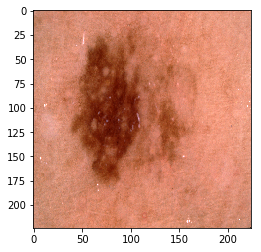

In [140]:
import cv2
test_img_path = '/home/carnd/dermatologist-ai/data/test/melanoma/ISIC_0015251.jpg'
test_img = imread(test_img_path)
test_img = cv2.resize(test_img,(224,224))
plt.imshow(test_img)

### 重新开启VGG模型

In [129]:
# 看看VGG是否已经开启
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

"vgg" object already exists.  Will not create again.


### 进行检测

In [130]:
with tf.Session() as sess:
    test_img1 = test_img.reshape(-1,224,224,3)
    feed_dict = {input_: test_img1}
    
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
    
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

In [131]:
prediction

array([ 1.,  0.,  0.], dtype=float32)

In [24]:
prediction = 
print("黑毒瘤的概率为 : %s" % prediction[1])
print("痣的概率为 : %s" % prediction[0])
print("普通斑的概率为 ：%s " % prediction[2])

SyntaxError: invalid syntax (<ipython-input-24-7a6fec6e8450>, line 1)

### 现场演示最后的结果

In [119]:
import glob
file_paths = glob.glob('/home/carnd/dermatologist-ai/data/test/nevus/'+r'*')

In [120]:
file_paths

['/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0015011.jpg',
 '/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0014994.jpg',
 '/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0015485.jpg',
 '/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0015973.jpg',
 '/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0015998.jpg',
 '/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0016014.jpg',
 '/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0014927.jpg',
 '/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0015003.jpg',
 '/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0016005.jpg',
 '/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0015237.jpg',
 '/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0014944.jpg',
 '/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0015582.jpg',
 '/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0014753.jpg',
 '/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0015954.jpg',
 '/home/carnd/dermatologist-ai/data/test/nevus/ISIC_0015037.jpg',
 '/home/ca

In [121]:

import cv2
test_img_path = '/home/carnd/dermatologist-ai/data/test/melanoma/ISIC_0015251.jpg'
test_img = imread(test_img_path)
test_img = cv2.resize(test_img,(224,224))


In [132]:
import cv2
test = None
predictions = []
for file in file_paths[:50]:
    test_img = imread(test_img_path)
    test_img = cv2.resize(test_img,(224,224))
    test_img = test_img.reshape(-1,224,224,3)
    if test is None:
        test = test_img 
    else:
        test = np.concatenate((test,test_img))


In [133]:
test.shape[0]

50

In [134]:
with tf.Session() as sess:
   
    feed_dict = {input_: test}
    
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
    
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

In [135]:

print("黑毒瘤的概率为 : %s" % prediction[1])
print("痣的概率为 : %s" % prediction[0])
print("普通斑的概率为 ：%s " % prediction[2])

黑毒瘤的概率为 : [ 1.  0.  0.]
痣的概率为 : [ 1.  0.  0.]
普通斑的概率为 ：[ 1.  0.  0.] 


In [136]:
prediction

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.